In [1]:
import numpy as np
import pandas as pd
from biom import load_table
from gneiss.util import match
from tensor_factor import TenAls
from deicode.optspace import OptSpace
from deicode.preprocessing import rclr
from IPython.core.display import HTML
pd.options.mode.chained_assignment = None  # default='warn'


#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
%matplotlib inline 

def plot_pcoa(x, y, samples, md, ax, factor_, colors_map=['#1f78b4','#e31a1c']):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    classes=np.sort(list(set(md[factor_].values)))
    cmap_out={}
    for sub_class,color_ in zip(classes,colors_map):
        idx = md[factor_] == sub_class        
        ax.scatter(samples.loc[idx, x],
           samples.loc[idx, y], 
           label=sub_class,
           facecolors=color_,
           edgecolors=color_,
           alpha=.8,linewidth=3)        
        cmap_out[sub_class]=color_
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PC1',fontsize=15)
    ax.set_ylabel('PC2',fontsize=15)
    
    return ax

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [2]:
# import the biom table
table = load_table('data/micemeth/reference-hit.biom')
# import taxa
taxa = pd.read_table('data/micemeth/taxonomy.tsv', index_col=0)
# import the metadata
meta = pd.read_table('data/micemeth/10537_20180929-125415.txt', index_col=0)

# filter sample to min depth
def sample_filter(val, id_, md): return sum(val) > 0
def observation_filter(val, id_, md): return sum(val) > 0
table = table.filter(sample_filter, axis='sample')
table = table.filter(observation_filter, axis='observation')

# ensure index matches
table,taxa = match(table.to_dataframe(),taxa)
table,meta = match(table.T,meta)

# rename table otus
table.columns=['sOTU'+str(i) for i in range(len(table.columns))]
taxa['sequence'] = taxa.index
taxa.index = table.columns

#view table
table.head(5)


,sOTU0,sOTU1,sOTU2,sOTU3,sOTU4,sOTU5,sOTU6,sOTU7,sOTU8,sOTU9,...,sOTU4690,sOTU4691,sOTU4692,sOTU4693,sOTU4694,sOTU4695,sOTU4696,sOTU4697,sOTU4698,sOTU4699
10537.p1e10.260.feb11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p5e4.25days.meth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,844.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p2g10.260.mar2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p2a10.260.feb19,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p6e5.33days.meth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,397.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
meta_mother = meta[meta.treatment_group.isin(['meth.mother','saline.mother'])]



### re-arrange into a tensor


In [22]:
# offspring
meta_offspring = meta[meta.treatment_group.isin(['meth.offspring','saline.offspring'])]
meta_offspring['ID'] =[x.split('.')[-1]+'_'+x.split('.')[1][3:] for x in meta_offspring.index]

# get table and filter features 
table_offspring,meta_offspring = match(table,meta_offspring)
table_offspring = table_offspring[table_offspring.sum(axis=1)>0]
table_offspring = table_offspring.T[table_offspring.sum()>0].T
table_offspring,meta_offspring = match(table_offspring,meta_offspring)

# table by timepoint
meta_offspring_time = {k:df for k,df in meta_offspring.groupby('timepoint')}

# remove samples not present in every timepoint
rmids = set([v_ for k_,df_ in meta_offspring_time.items() 
             for v_ in list(set(meta_offspring['ID'])-set(df_['ID']))])
meta_offspring = meta_offspring[~meta_offspring.ID.isin(list(rmids))]

#final match
table_offspring = table_offspring.T[table_offspring.sum()>300].T
table_offspring,meta_offspring = match(table_offspring,meta_offspring)


In [23]:
# table by timepoint
meta_offspring_time = {k:df for k,df in meta_offspring.groupby('timepoint')}
# create tensor
tensor_offspring = []
for timepoint in sorted(meta_offspring_time.keys()):
    table_tmp,meta_tmp = match(table_offspring,meta_offspring_time[timepoint])
    meta_tmp.set_index('ID',inplace=True,drop=True)
    table_tmp = table_tmp.T.sort_index().T
    table_tmp.index = meta_tmp.index
    table_tmp.sort_index(inplace=True)
    meta_tmp.sort_index(inplace=True)
    meta_offspring_time[timepoint] = meta_tmp
    tensor_offspring.append(table_tmp)
TOff = np.dstack(tensor_offspring).T
TOff.shape


(11, 369, 19)

In [24]:
from collections import Counter
TOff_f = np.concatenate([TOff[i,:,:].T for i in range(TOff.shape[0])],axis=0)

Counter(TOff_f.sum(axis=0))[0]

0

In [25]:
# flatten, transform, and reshape 
TOff_rclr = np.concatenate([TOff[i,:,:].T for i in range(TOff.shape[0])],axis=0)
TOff_rclr = rclr().fit_transform(TOff_rclr)


In [26]:

TOff_rclr = np.dstack([TOff_rclr[(i-1)*TOff.shape[-1]:(i)*TOff.shape[-1]] for i in range(1,TOff.shape[0]+1)])
#TOff_rclr = TOff.copy()
TOff_rclr[np.isnan(TOff_rclr)] = 0 
E = np.zeros(TOff_rclr.shape)
E[abs(TOff_rclr)>0] = 1


In [27]:
%%time
# Compostional-TenAls
L1,L2,L3,s,dist = TenAls(TOff_rclr,E)


CPU times: user 3.92 s, sys: 58 ms, total: 3.97 s
Wall time: 2.19 s


In [28]:
# make df
offtime_ordin = pd.DataFrame(L3,sorted(meta_offspring_time.keys()),columns=['PC1','PC2'])
offfeature_ordin = pd.DataFrame(L2,table_offspring.columns,columns=['PC1','PC2'])
offsample_ordin = pd.DataFrame(L1,table_tmp.index,columns=['PC1','PC2'])



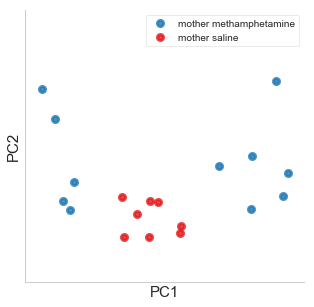

In [29]:
fig,ax = plt.subplots(1,1,figsize=(5,5))


_ = plot_pcoa('PC2', 'PC1', offsample_ordin, meta_tmp, ax, 'treated')

plt.legend()
plt.show()


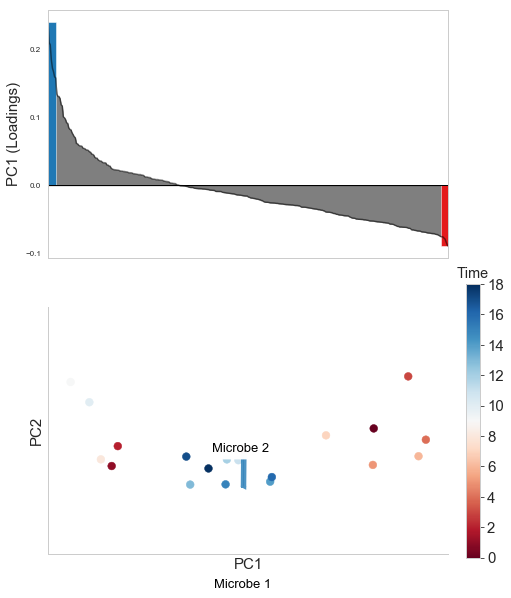

In [13]:
fig,(ax1,ax) = plt.subplots(2,1,figsize=(8,10), facecolor='white')

## loadings ##
L2df = pd.DataFrame(L2).sort_values(0,ascending=False).reset_index(drop=True)

colormap_ = {L2df.index[0]:'#1f78b4',
            L2df.index[-1]:'#e41a1c'}
L2df_bar = L2df.copy()
L2df_bar.loc[list(set(L2df_bar.index) - set(colormap_.keys()))]=0
for ind_ in L2df_bar.index:
    if ind_ not in colormap_.keys():
        colormap_[ind_]='#3f4244'  
L2df_bar[0].plot(kind='bar',color=[colormap_[x] for x in L2df_bar.index], 
             width=14,ax=ax1)
L2df[0].plot(kind='area',color='black',stacked=False, 
             ax=ax1, fontsize=8)
ax1.set_xticks([])
ax1.set_ylabel('PC1 (Loadings)',fontsize=15)
ax1.axhline(0,c='black',lw=1,ls='-')
ax1.set_xlim(min(L2df.index),max(L2df.index))
ax1.grid()

## biplot ##

#Call the function. Use only the 2 PCs.
sc = ax.scatter(L1[:,1],L1[:,0], 
            c = np.array(range(L1.shape[0])), 
            cmap='RdBu',s=60)
#cbar = fig.colorbar(sc, ax=ax)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.12, 0.025, 0.38])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15) 
cbar.ax.set_title('Time')

# biplot
vectors = L2[[0,-1],:]
for i,c_ in zip(range(vectors.shape[0]),['#1f78b4','#e41a1c']):
    ax.arrow(np.mean(L1[:,1]), np.mean(L1[:,0]), 
              vectors[i,1]*.15, vectors[i,0]*.15,
              head_width=0.0006, head_length=0.0006, 
             fc=c_, ec=c_, lw=5, alpha =.8)
    
    props = dict(boxstyle='round', facecolor='white', alpha=.99)
    ax.text((np.mean(L1[:,1])+vectors[i,1]/1.8), 
             (np.mean(L1[:,0])+vectors[i,0]/1.8), 
             "Microbe "+str(i+1), color = 'k', 
             ha = 'center', va = 'center', bbox=props, fontsize=13)
    
ax.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PC1',fontsize=15)
ax.set_ylabel('PC2',fontsize=15)

plt.show()


In [134]:
TOff.reshape(-1, TOff.shape[-1]).shape

(209, 1421)

In [135]:
TOff.shape

(19, 1421, 11)

In [121]:
TOff.reshape(-1, TOff.shape[1]).shape


(209, 1421)

In [117]:
table.sum(axis=0).min()

11.0